<a href="https://colab.research.google.com/github/khushib004/Natural-Language-Processing/blob/main/Mental_Health_Chatbot_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip uninstall -y tensorflow tensorflow-hub tensorflow-text keras tensorboard ml-dtypes
!pip install --no-cache-dir tensorflow-hub==0.15
!pip install tensorflow-text==2.15
!pip install tensorflow==2.15

In [ ]:
!pip install pandas transformers
!pip install transformers
!pip install torch
!pip install datasets
!pip install scikit-learn
import tensorflow as tf
import tensorflow_hub as hub
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from transformers import Trainer, TrainingArguments
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
import tensorflow_text as text
from tensorflow.keras.utils import to_categorical

# **Data Handling And Preprocessing**

In [ ]:
# Replace 'your_excel_file.xlsx' with the actual name of your uploaded Excel file
file_name = 'MERGED MENTAL H DATASET (5).xlsx'

# Read the Excel file
df = pd.read_excel(file_name)

# Display the first 5 rows of the DataFrame
print(df.head())


  subreddit       date                                               post  \
0      adhd 2020-01-01  ADHD gets worse at night High school senior he...   
1      adhd 2020-01-01  The First Step of a multi-step task Perhaps yo...   
2      adhd 2020-01-01  I have been carrying around Play-Doh for years...   
3      adhd 2020-01-01  How do you keep from getting bored in a relati...   
4      adhd 2020-01-01  I need entertain Hello I used to play games li...   

  Post/Pre  
0     post  
1     post  
2     post  
3     post  
4     post  


In [ ]:
#check the distribution of labels
df['subreddit'].value_counts()

anxiety       58568
depression    55887
adhd          30298
ptsd           6542
alcoholism     4515
Name: subreddit, dtype: int64

In [ ]:
#DOWNSIZING DATA
min_samples = 6542  # Define the number of samples to match the minority class

# Replace 'df_ham_downsampled' with a list of downsampled DataFrames for each subreddit
# We use the same 'min_samples' and 'random_state' for consistency
subreddits = ['depression', 'anxiety', 'adhd', 'ptsd']

# Dictionary comprehension to downsample each subreddit DataFrame
dfs_downsampled = {subreddit: df[df.subreddit == subreddit].sample(min_samples, random_state=2022) for subreddit in subreddits}

# If you want to access one of them, for example, the downsampled DataFrame for 'depression':
df_depression_downsampled = dfs_downsampled['depression']
df_anxiety_downsampled = dfs_downsampled['anxiety']
df_adhd_downsampled = dfs_downsampled['adhd']
df_ptsd_downsampled = dfs_downsampled['ptsd']
df_alcoholism_downsampled = df[df.subreddit == 'alcoholism']  # No downsampling applied


In [ ]:
df_balanced = pd.concat([df_depression_downsampled, df_anxiety_downsampled,df_adhd_downsampled, df_ptsd_downsampled, df_alcoholism_downsampled])
df_balanced.shape

(30683, 4)

In [ ]:
df_balanced['subreddit'].value_counts()

depression    6542
anxiety       6542
adhd          6542
ptsd          6542
alcoholism    4515
Name: subreddit, dtype: int64

In [ ]:
df['label'] = df['subreddit'].map({'depression' : 0, 'anxiety': 1,'adhd' : 2, 'ptsd': 3,'alcoholism' : 4})

In [ ]:
df.head()

,subreddit,date,post,Post/Pre,label
0,adhd,2020-01-01,ADHD gets worse at night High school senior he...,post,2
1,adhd,2020-01-01,The First Step of a multi-step task Perhaps yo...,post,2
2,adhd,2020-01-01,I have been carrying around Play-Doh for years...,post,2
3,adhd,2020-01-01,How do you keep from getting bored in a relati...,post,2
4,adhd,2020-01-01,I need entertain Hello I used to play games li...,post,2


# **BERT for Tokenization and Vectorization**

In [ ]:
from transformers import BertTokenizer
import torch

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define the max length for BERT
max_length = 128  # You can adjust this according to the needs and constraints of your model

# Function to tokenize and encode the dataset
def encode_texts(texts):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,                        # Text to encode
            add_special_tokens=True,     # Add '[CLS]' and '[SEP]'
            max_length=max_length,       # Pad or truncate
            pad_to_max_length=True,      # Pad all to `max_length` if necessary
            return_attention_mask=True,  # Construct attn. masks
            return_tensors='pt',         # Return pytorch tensors
        )

        # Add the encoded sentence to the list
        input_ids.append(encoded_dict['input_ids'])
        # And its attention mask (differentiating padding from non-padding)
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert lists to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Preprocess the 'post' column
posts = df['post'].values  # Extract text data to preprocess
input_ids, attention_masks = encode_texts(posts)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# **Model Architecture and Training Process**


In [ ]:
# Parameters
BATCH_SIZE = 16
EPOCHS = 3

# Load and preprocess dataset
# df = pd.read_csv('your_large_dataset.csv')  # Load your dataset
posts = df['post'].values
subreddits = df['subreddit'].values

# Encode labels
label_encoder = LabelEncoder()
subreddits_encoded = label_encoder.fit_transform(subreddits)
subreddits_encoded = to_categorical(subreddits_encoded)

# Split dataset
train_posts, test_posts, train_labels, test_labels = train_test_split(posts, subreddits_encoded, test_size=0.1)

# Convert to tf.data.Dataset for efficient loading
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = tf.data.Dataset.from_tensor_slices((train_posts, train_labels))
train_data = train_data.shuffle(buffer_size=len(train_posts)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_data = tf.data.Dataset.from_tensor_slices((test_posts, test_labels)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# BERT layers
bert_preprocess_model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_model_url = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2'

# Build the model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.KerasLayer(bert_preprocess_model_url, name='preprocessing')
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(bert_model_url, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(subreddits_encoded.shape[1], activation='softmax', name='classifier')(net)
model = tf.keras.Model(text_input, net)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_data, epochs=EPOCHS, validation_data=test_data)

# Evaluate the model
model.evaluate(test_data)

Epoch 1/3
8765/8765 [==============================] - 2866s 326ms/step - loss: 0.5125 - accuracy: 0.8139 - val_loss: 0.3867 - val_accuracy: 0.8652
Epoch 2/3
8765/8765 [==============================] - 2807s 320ms/step - loss: 0.3831 - accuracy: 0.8642 - val_loss: 0.3677 - val_accuracy: 0.8699
Epoch 3/3
974/974 [==============================] - 87s 89ms/step - loss: 0.3670 - accuracy: 0.8738


[0.3670276701450348, 0.8737565279006958]

In [ ]:
loss, accuracy = model.evaluate(test_data)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

974/974 [==============================] - 135s 138ms/step - loss: 0.3670 - accuracy: 0.8738
Test Loss: 0.3670276701450348
Test Accuracy: 0.8737565279006958


In [ ]:
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

974/974 [==============================] - 86s 88ms/step


# **Error** **Analysis**

In [ ]:
from sklearn.metrics import classification_report

# Convert test labels from one-hot encoding to integers
test_labels_integers = np.argmax(test_labels, axis=1)

# Convert predicted labels back to original subreddit labels
predicted_subreddits = label_encoder.inverse_transform(predicted_labels)
true_subreddits = label_encoder.inverse_transform(test_labels_integers)

# Generate and print the classification report
print(classification_report(true_subreddits, predicted_subreddits, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

        adhd       0.90      0.90      0.90      2979
  alcoholism       0.89      0.85      0.87       462
     anxiety       0.87      0.88      0.87      5917
  depression       0.87      0.86      0.87      5611
        ptsd       0.78      0.78      0.78       612

    accuracy                           0.87     15581
   macro avg       0.86      0.85      0.86     15581
weighted avg       0.87      0.87      0.87     15581



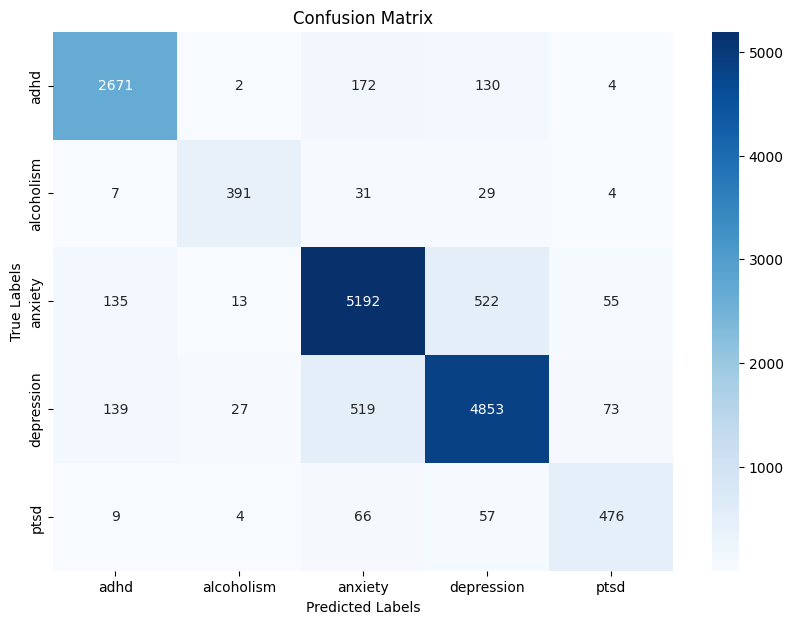

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming true_subreddits and predicted_subreddits are your actual and predicted labels respectively
# You may need to run your prediction and label encoding steps again if they're not stored

# Compute the confusion matrix
cm = confusion_matrix(true_subreddits, predicted_subreddits, labels=label_encoder.classes_)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# **Testing**

In [ ]:
#PTSD RANDOM COMMENT
new_posts = ["anyone have any advice on projecting? i told my counselor about how one of my biggest issues is projecting trauma onto other people and she only kind of explained why i probably do it, but didn't really give me any advice on what to do about it. has anyone dealt with this and figured out ways of not doing it? i hate that i do it because it's not fair for me to be projecting past things onto other people that have nothing to do with it"]  # Add your text here
processed_posts = tf.data.Dataset.from_tensor_slices((new_posts, [0]))  # Dummy labels
processed_posts = processed_posts.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Predicting new texts
new_predictions = model.predict(processed_posts)
new_predicted_labels = np.argmax(new_predictions, axis=1)
new_predicted_labels = label_encoder.inverse_transform(new_predicted_labels)  # Convert back to original labels
print(new_predicted_labels)


1/1 [==============================] - 0s 416ms/step
['ptsd']


In [ ]:
#ADHD RANDOM COMMENT
new_posts = ["English assignment So i have to do this English assignment about how certain groups are misrepresented in the media, i hyper focused it in one night and the speech was brilliant, problem was i didn't understand the scaffolding and spoke about how the misrepresentations were wrong and not how they are actually being misrepresented, anyways i have to rewrite alot of it and it's due after this weekend. I need a text that shows a misrepresentation of ADHD that is Australian. It can be a movie, poem or news report. Fuck this is the only place i thought i could put this and my teacher is a hard ass stalinist marker."]
processed_posts = tf.data.Dataset.from_tensor_slices((new_posts, [0]))  # Dummy labels
processed_posts = processed_posts.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Predicting new texts
new_predictions = model.predict(processed_posts)
new_predicted_labels = np.argmax(new_predictions, axis=1)
new_predicted_labels = label_encoder.inverse_transform(new_predicted_labels)  # Convert back to original labels
print(new_predicted_labels)

1/1 [==============================] - 0s 25ms/step
['adhd']


In [ ]:
#ALCOHOLISM RANDOM COMMENT
new_posts = ["Looking for answers So this is new to me. I‚Äôm going to be brief. And if this isn‚Äôt the right forum for it please redirect me where I should go. I‚Äôm not an alcoholic, in my own eyes anyway. I don‚Äôt drink everyday. I don‚Äôt crave alcohol. I have no issues being sober. The problem is when I do drink I binge. Sometimes I can sit and have a few drinks and just be fine. But most times I drink way past the point I ever should. I don‚Äôt know what I should do.  I‚Äôve debated giving up drinking completely. I‚Äôve debated giving myself a one drink limit. I was just wondering if anyone had any similar experiences? Any help is welcome!"]
processed_posts = tf.data.Dataset.from_tensor_slices((new_posts, [0]))  # Dummy labels
processed_posts = processed_posts.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Predicting new texts
new_predictions = model.predict(processed_posts)
new_predicted_labels = np.argmax(new_predictions, axis=1)
new_predicted_labels = label_encoder.inverse_transform(new_predicted_labels)  # Convert back to original labels
print(new_predicted_labels)

1/1 [==============================] - 0s 21ms/step
['alcoholism']
